#  <font color='dark gary'> Anomaly detection method
https://scikit-learn.org/stable/modules/outlier_detection.html#outlier-detection
<img src = 'https://sdk.finance/wp-content/uploads/2021/04/anomaly_detection-768x512.png'>

### 1. Supervised learning
### 2. Semi-Supervised learning (Novelty detection)
- 새로운 한번도 보지 못한 데이터가 outlier인지 아닌지 판단(훈련데이터에 outlier가 없음)

### 3. Unsupervised learning (Outlier detection)
- inlier와 outlier를 포함한 훈련데이터에서 outliers를 탐색
        * Anomaly는 outlier와 novelty를 모두 호칭

https://github.com/yzhao062/anomaly-detection-resources
- 응용 분야
     * Data cleaning
     * Fraud detection like credit card frauds or security breaches
     * Health monitoring of people, systems, and machines

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.rcParams['font.family']='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False 
get_ipython().run_line_magic('matplotlib', 'inline')

# <font color='red'> 1. Supervised Learning

In [2]:
from sklearn.datasets import load_boston
boston_dataset = load_boston()
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


## 1.1 Interquartile Range(IQR) - Box plot으로 outlier 탐색
단일 변수의 백분위수 (range)를 확인하여 이상치(outlier)를 그려보고 확인한다

In [3]:
boston.skew().sort_values(ascending=False)
boston.kurt().sort_values(ascending=False)

CRIM       5.223149
CHAS       3.405904
ZN         2.225666
DIS        1.011781
RAD        1.004815
LSTAT      0.906460
NOX        0.729308
TAX        0.669956
RM         0.403612
INDUS      0.295022
AGE       -0.598963
PTRATIO   -0.802325
B         -2.890374
dtype: float64

CRIM       37.130509
CHAS        9.638264
B           7.226818
ZN          4.031510
RM          1.891500
LSTAT       0.493240
DIS         0.487941
NOX        -0.064667
PTRATIO    -0.285091
RAD        -0.867232
AGE        -0.967716
TAX        -1.142408
INDUS      -1.233540
dtype: float64

<AxesSubplot:>

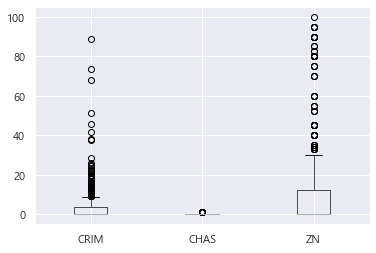

In [4]:
cols = ['CRIM','CHAS','ZN']
boston.boxplot(column=cols)

In [11]:
def Outliers(col):
    q1, q3 =col.quantile(0.15), col.quantile(0.95)
    iqr = q3 - q1
    l_fence, u_fence = q1 - 1.5*iqr , q3 + 1.5*iqr  
    outliers = col[(col < l_fence) | (col > u_fence)] 
    if outliers.count() > 0 :
        print(col.name,'의 총 이상치 관측 수:', outliers.count())
        print('Lower fence: ', l_fence, 'Upper fence: ', u_fence) #filtering = col.drop(outliers.index, axis = 0)
    print('*'*100)
        
for col in boston.columns:
    Outliers(boston[col])

CRIM 의 총 이상치 관측 수: 6
Lower fence:  -23.5568 Upper fence:  39.39672
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
************************

## 1.2 확률밀도함수로 이상치 확인

단일변수의 확률밀도 함수를 확인하여 이상치를 p-value로 확인한다

z = 1.96의 pdf: 0.942, z = 2.58의 pdf: 0.986


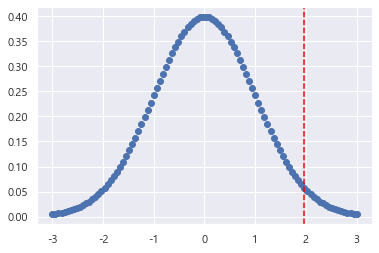

In [12]:
import scipy as sp
sp.stats.norm(loc=0, scale=1) # 평균0, 표준편차 1
rv = sp.stats.norm(loc=0, scale=1)
print(f'z = 1.96의 pdf: {1- rv.pdf(1.96):.3f}, z = 2.58의 pdf: {1- rv.pdf(2.58):.3f}')
plt.scatter(np.linspace(-3,3,100), rv.pdf(np.linspace(-3,3,100)))
plt.axvline(x=1.96, color='red', linestyle='--')

Text(0.5, 0, 'instances')

Text(0, 0.5, 'pdf(probability density function)')

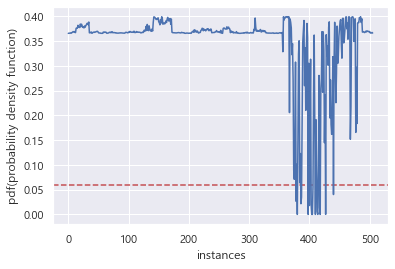

In [13]:
z = (boston['CRIM'] - boston['CRIM'].mean())/boston['CRIM'].std()
plt.axhline(y= rv.pdf(1.96), color='r', linestyle='--')
plt.plot(rv.pdf(z))
plt.xlabel('instances'); plt.ylabel('pdf(probability density function)')

가우시안 분포를 가정하여 pdf(probability density distribution)이 임계치를 넘으면 이상치라고 판단

<AxesSubplot:>

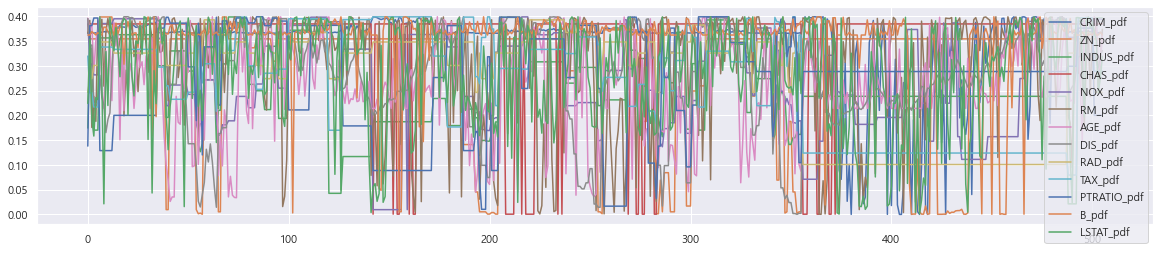

In [14]:
for col in boston.columns:
    boston[col] = (boston[col] -boston[col].mean())/boston[col].std()
    boston[col + '_pdf'] = rv.pdf(boston[col])
data = boston.loc[:, 'CRIM_pdf':'LSTAT_pdf']
data.plot(figsize=(20,4))

## 1.3 K-Nearest neighbors 이상치 확인
- Unsupervised K-Nearest Neighbors
- https://scikit-learn.org/stable/modules/neighbors.html
- SVM도 SVM hyperplane에서 거리를 기준으로 이상치 확인 가능

NearestNeighbors(n_neighbors=3)

<AxesSubplot:>

Text(0.5, 1.0, 'Distance mean of KNN')

Text(0.5, 0, 'Instances')

Text(0, 0.5, 'Mean of Distance')

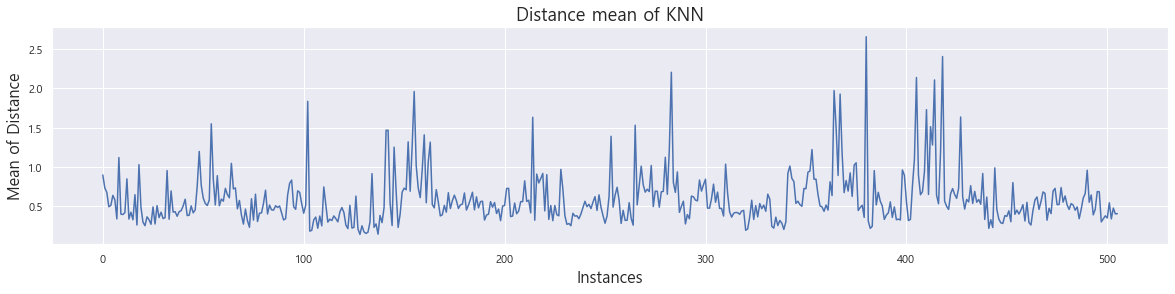

In [15]:
from sklearn.neighbors import NearestNeighbors
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
nbrs = NearestNeighbors(n_neighbors = 3)
nbrs.fit(boston)
distances, indices = nbrs.kneighbors(boston) # distances : distances between data points
                                           # indices : associated index values
pd.Series(distances.mean(axis =1)).plot(figsize=(20,4))
plt.title('Distance mean of KNN', fontsize = 18)
plt.xlabel('Instances', fontsize = 16); plt.ylabel('Mean of Distance', fontsize = 16)

### Spike 되는 instance는 anomaly이며, 평균 거리가 '2.0'이상이면 이상치라고 판단

In [16]:
outlier_index = np.where(distances.mean(axis = 1) > 2.0)
boston.iloc[outlier_index]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
283,-0.418357,3.371702,-1.446978,3.664771,-1.326356,2.331804,-1.555122,0.992519,-0.981871,-1.247423,-2.242797,0.425500,-1.329363
380,9.924110,-0.487240,1.014995,-0.272329,1.003687,0.972600,0.828634,-1.129568,1.659603,1.529413,0.805778,0.440616,0.638132
405,7.476247,-0.487240,1.014995,-0.272329,1.193543,-0.856276,1.116390,-1.125341,1.659603,1.529413,0.805778,0.309940,1.446135
414,4.898257,-0.487240,1.014995,-0.272329,1.193543,-2.512940,1.116390,-1.014785,1.659603,1.529413,0.805778,-2.939969,3.406628
418,8.128839,-0.487240,1.014995,-0.272329,1.072726,-0.466306,1.116390,-0.946209,1.659603,1.529413,0.805778,-3.726650,1.115652


### 불균형데이터 유형
- 이상치는 극히 심한 불균형데이터와 같은 유형을 갖는다.
- make_classification() 함수에 클라스를 무작위로 교환하여 분류를 어렵게 함, flip_y=0

### 단변량으로 시각화하면 이상치를 발견하기 어려움

<Figure size 1440x360 with 0 Axes>

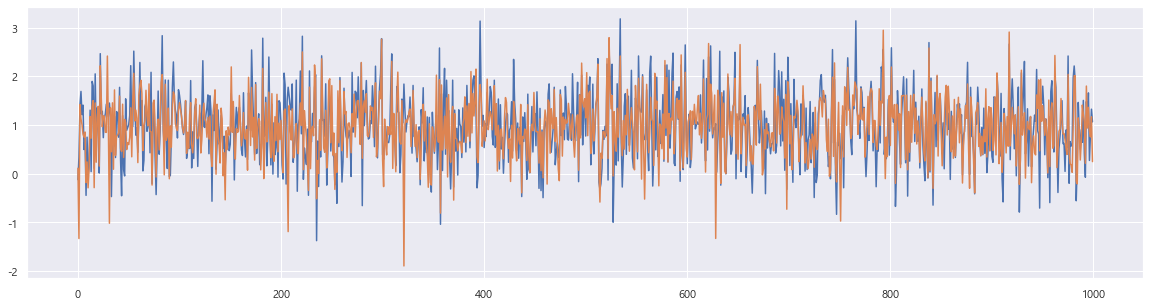

In [17]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
plt.figure(figsize=(20,5))
plt.plot(X[:, 0]); plt.plot(X[:, 1])

### 다변량, combination으로 시각화하면 이상치를 발견할 수있음

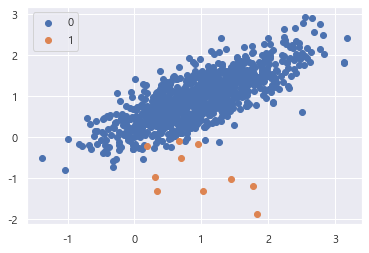

In [18]:
from collections import Counter
for label, _ in Counter(y).items():
    row_ix = np.where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()

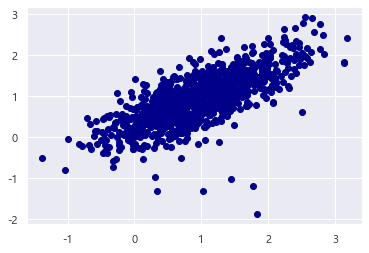

In [19]:
plt.scatter(X[:, 0], X[:, 1], c='darkblue')
plt.show()

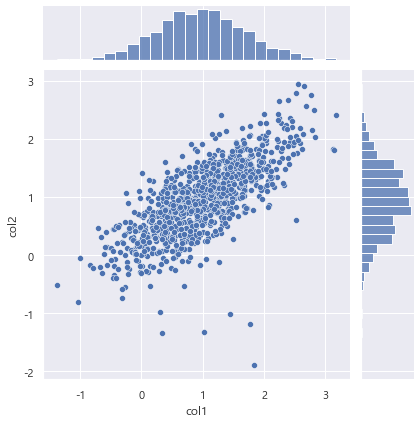

In [20]:
data= pd.DataFrame(X, columns=['col1', 'col2'])
sns.jointplot(data=data, x='col1', y='col2')

<Figure size 1080x360 with 0 Axes>

Text(0.5, 0, 'col1')

Text(0, 0.5, 'col2')

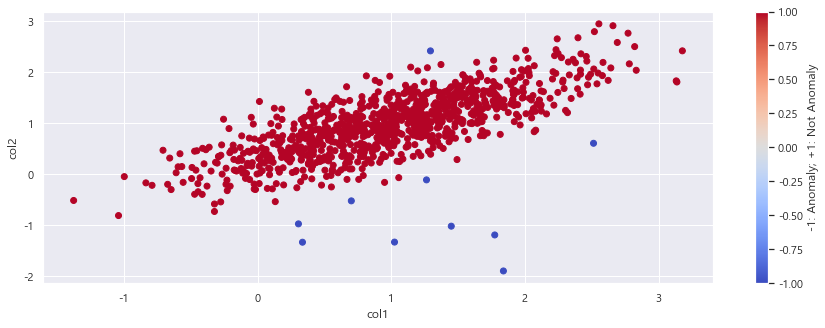

In [21]:
from sklearn.covariance import EllipticEnvelope
data= pd.DataFrame(X, columns=['col1', 'col2'])
el = EllipticEnvelope(store_precision=True, assume_centered=False, support_fraction=None, 
                      contamination=0.01, random_state=0)

data['Anomaly or Not'] = el.fit(data).predict(data)
plt.figure(figsize = (15, 5))
ax = plt.scatter(data['col1'], data['col2'], c = data['Anomaly or Not'], cmap = 'coolwarm')
plt.xlabel('col1'); plt.ylabel('col2')
plt.colorbar(label = '-1: Anomaly; +1: Not Anomaly')

### PCA anomaly

Text(0.5, 0, '주성분 개 수')

Text(0, 0.5, '총변동량 누적 설명 비율')

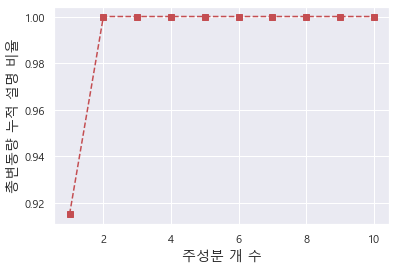

In [22]:
from sklearn.decomposition import PCA
X, y = make_classification(n_samples=1000, n_features=10, n_redundant=8,
                           n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
pca = PCA().fit(X)
plt.plot(np.arange(1, X.shape[1]+1), np.cumsum(pca.explained_variance_ratio_), 'rs--')
plt.xlabel('주성분 개 수', fontsize='14'); plt.ylabel('총변동량 누적 설명 비율', fontsize='14')

EllipticEnvelope(contamination=0.01, random_state=0)

<Figure size 1080x360 with 0 Axes>

Text(0.5, 0, 'pca_1')

Text(0, 0.5, 'pca_2')

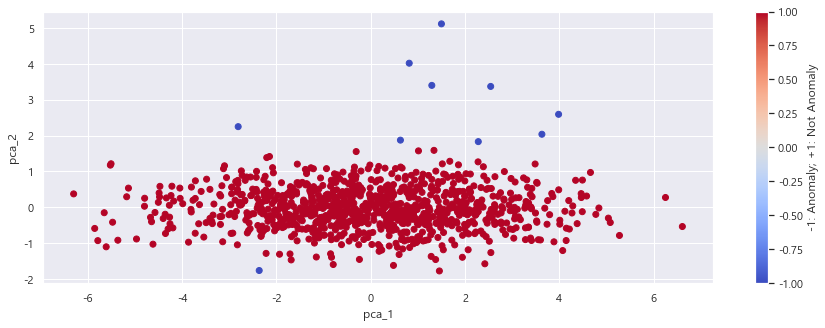

In [23]:
X_pca = PCA(n_components=2).fit(X).transform(X)
X_pca = pd.DataFrame(X_pca, columns= ['pca_1', 'pca_2'])
plt.rcParams['axes.unicode_minus'] = False

el.fit(X_pca)
X_pca['Anomaly or Not'] = el.predict(X_pca)
# Create scatterplot and color the anomalies differently
plt.figure(figsize = (15, 5))
ax = plt.scatter(X_pca['pca_1'], X_pca['pca_2'], c = X_pca['Anomaly or Not'], cmap = 'coolwarm')
plt.xlabel('pca_1'); plt.ylabel('pca_2')
plt.colorbar(label = '-1: Anomaly; +1: Not Anomaly')

### Robust covariance estimation and Mahalanobis distances relevance
https://scikit-learn.org/stable/auto_examples/covariance/plot_mahalanobis_distances.html

In [24]:
from sklearn.covariance import EmpiricalCovariance, MinCovDet
n_outliers = np.sum(y) # int(X.shape[0]*0.01), outlier의 개수
n_samples = X.shape[0]

robust_cov = MinCovDet().fit(X) # fit a MCD robust estimator to data
emp_cov = EmpiricalCovariance().fit(X) # fit a MLE estimator to data
pd.DataFrame(robust_cov.covariance_)

,0,1,2,3,4,5,6,7,8,9
0,0.448514,0.112830,-0.534321,0.266231,-0.412492,-0.065352,0.343979,0.347469,-0.012240,0.295145
1,0.112830,0.078305,-0.120105,0.023533,-0.096786,-0.069200,0.110587,0.115901,0.006166,0.091255
2,-0.534321,-0.120105,0.640647,-0.329618,0.493409,0.062731,-0.402891,-0.405778,0.017232,-0.346736
3,0.266231,0.023533,-0.329618,0.195834,-0.250925,0.007120,0.183249,0.181460,-0.015311,0.160395
4,-0.412492,-0.096786,0.493409,-0.250925,0.380340,0.052724,-0.312988,-0.315578,0.012550,-0.269062
5,-0.065352,-0.069200,0.062731,0.007120,0.052724,0.065282,-0.075542,-0.080740,-0.007987,-0.060979
6,0.343979,0.110587,-0.402891,0.183249,-0.312988,-0.075542,0.275398,0.280212,-0.004933,0.234550
7,0.347469,0.115901,-0.405778,0.181460,-0.315578,-0.080740,0.280212,0.285448,-0.004206,0.238358
8,-0.012240,0.006166,0.017232,-0.015311,0.012550,-0.007987,-0.004933,-0.004206,0.002046,-0.004905
9,0.295145,0.091255,-0.346736,0.160395,-0.269062,-0.060979,0.234550,0.238358,-0.004905,0.200015


{'whiskers': [<matplotlib.lines.Line2D at 0x241bb389dc0>,
 'caps': [<matplotlib.lines.Line2D at 0x241bd4ba520>,
 'boxes': [<matplotlib.lines.Line2D at 0x241bb389a30>,
 'medians': [<matplotlib.lines.Line2D at 0x241bd4bac40>,
 'fliers': [<matplotlib.lines.Line2D at 0x241bd4bafd0>,
 'means': []}

[Text(1, 0, 'inliers'), Text(2, 0, 'outliers')]

Text(0, 0.5, '$\\sqrt[3]{\\rm{(Mahal. dist.)}}$')

Text(0.5, 1.0, 'Using non-robust estimates\n(Maximum Likelihood)')

{'whiskers': [<matplotlib.lines.Line2D at 0x241bd4e38b0>,
 'caps': [<matplotlib.lines.Line2D at 0x241bd4e3fd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x241bd4e32e0>,
 'medians': [<matplotlib.lines.Line2D at 0x241bd4e2730>,
 'fliers': [<matplotlib.lines.Line2D at 0x241bd4e2ac0>,
 'means': []}

[Text(1, 0, 'inliers'), Text(2, 0, 'outliers')]

Text(0, 0.5, '$\\sqrt[3]{\\rm{(Mahal. dist.)}}$')

Text(0.5, 1.0, 'Using robust estimates\n(Minimum Covariance Determinant)')

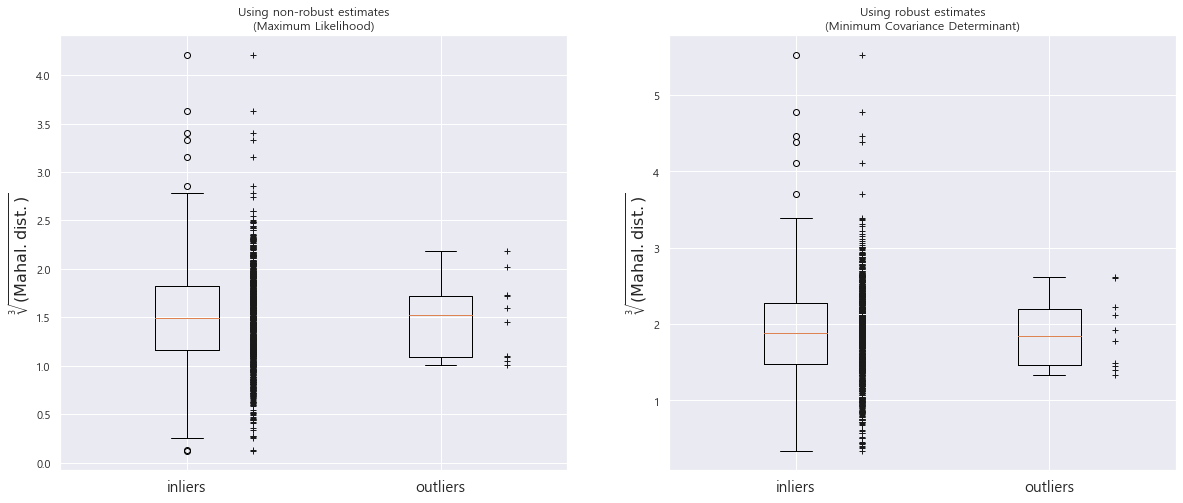

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

# Calculate cubic root of MLE Mahalanobis distances for samples
emp_mahal = emp_cov.mahalanobis(X - np.mean(X, 0)) ** (0.33)
ax1.boxplot([emp_mahal[:-n_outliers], emp_mahal[-n_outliers:]], widths=.25)
# Plot individual samples
ax1.plot(np.full(n_samples - n_outliers, 1.26), emp_mahal[:-n_outliers],
         '+k', markeredgewidth=1)
ax1.plot(np.full(n_outliers, 2.26), emp_mahal[-n_outliers:],
         '+k', markeredgewidth=1)
ax1.axes.set_xticklabels(('inliers', 'outliers'), size=15)
ax1.set_ylabel(r"$\sqrt[3]{\rm{(Mahal. dist.)}}$", size=16)
ax1.set_title("Using non-robust estimates\n(Maximum Likelihood)")

# Calculate cubic root of MCD Mahalanobis distances for samples
robust_mahal = robust_cov.mahalanobis(X - robust_cov.location_) ** (0.33)
ax2.boxplot([robust_mahal[:-n_outliers], robust_mahal[-n_outliers:]],
            widths=.25)
# Plot individual samples
ax2.plot(np.full(n_samples - n_outliers, 1.26), robust_mahal[:-n_outliers],
         '+k', markeredgewidth=1)
ax2.plot(np.full(n_outliers, 2.26), robust_mahal[-n_outliers:],
         '+k', markeredgewidth=1)
ax2.axes.set_xticklabels(('inliers', 'outliers'), size=15)
ax2.set_ylabel(r"$\sqrt[3]{\rm{(Mahal. dist.)}}$", size=16)
ax2.set_title("Using robust estimates\n(Minimum Covariance Determinant)")

### Isolation anomaly

In [26]:
from sklearn.ensemble import IsolationForest
df = pd.DataFrame(X, columns= ['col'+ str(i+1) for i in range(X.shape[1])])
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(df.values.reshape(-1, 1))
anomaly_score = isolation_forest.decision_function(df['col1'].values.reshape(-1, 1))
outlier = isolation_forest.predict(df['col1'].values.reshape(-1, 1))
data = pd.DataFrame(np.c_[anomaly_score, outlier], columns = ['anomaly_score', 'outlier'])
data.reset_index(inplace=True)
data.sample(5)
data['outlier'].value_counts(normalize=True)

IsolationForest()

,index,anomaly_score,outlier
469,469,0.069754,1.0
463,463,0.071562,1.0
97,97,-0.110619,-1.0
233,233,-0.012256,-1.0
367,367,0.070922,1.0


 1.0    0.631
-1.0    0.369
Name: outlier, dtype: float64

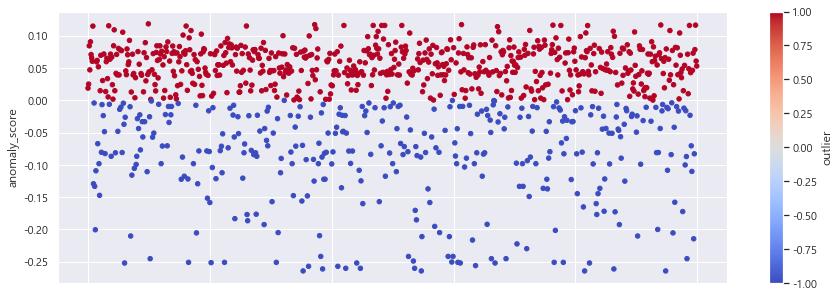

In [27]:
ax2 = data.plot.scatter(x='index', y='anomaly_score',
                        c='outlier',
                        colormap='coolwarm',
                        figsize=(15,5))

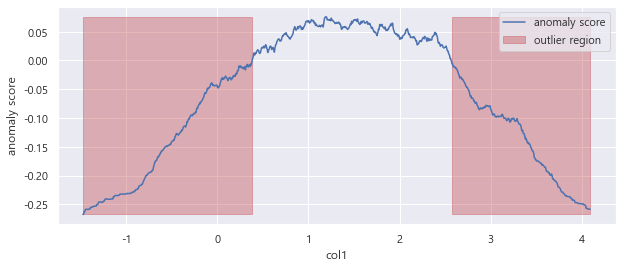

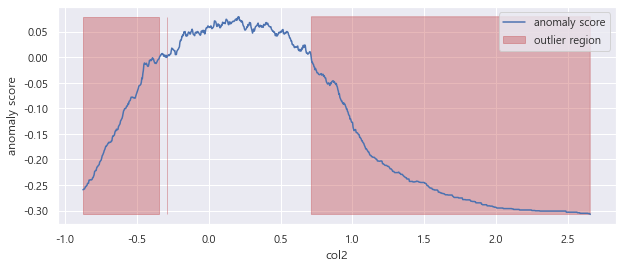

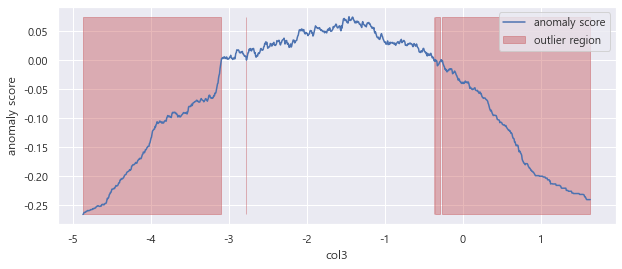

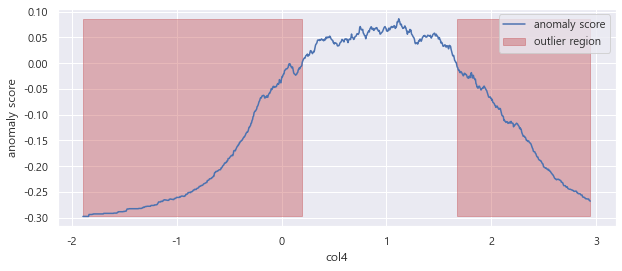

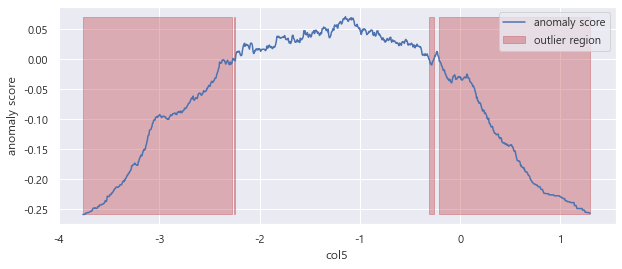

In [28]:
def Iforest(col):
    isolation_forest.fit(df[col].values.reshape(-1, 1))
    xx = np.linspace(df[col].min(), df[col].max(), len(df)).reshape(-1,1)
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    plt.figure(figsize=(10,4))
    plt.plot(xx, anomaly_score, label='anomaly score')
    plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                     where=outlier==-1, color='r', alpha=.4, label='outlier region')
    plt.legend()
    plt.ylabel('anomaly score')
    plt.xlabel(col)
    plt.show();

for col in df.columns[0:5]:
    Iforest(col)

#  <font color='red'> 2. Semi-Supervised learning (Novelty detection)
## One-class SVM with non-linear kernel (RBF)
- OCSVM assumes that anomalies can form dense clusters as long as they form a low-density region in the training dataset.
- OCSVM mode is trained in only one class, referred to as the normal class. The model learns all the features and patterns of the normal class 
- https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM

#### <p> <font color= 'blue'> Intuition : One-class SVM is based on SVM, which uses a hyperplane to seperate two classes while a  <b>One-class SVM uses a hypersphere to emcompass all of the observations<b> <p>

In [29]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/'
df = pd.read_csv(url + 'breast-cancer-wisconsin.data')
df.columns = ['Sample code number', 'Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape',
      'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin',
      'Normal Nucleoli', 'Mitoses', 'Class'] # (2 for benign, 4 for malignant)
df.head()

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1002945,5,4,4,5,7,10,3,2,1,2
1,1015425,3,1,1,1,2,2,3,1,1,2
2,1016277,6,8,8,1,3,4,3,7,1,2
3,1017023,4,1,1,3,2,1,3,1,1,2
4,1017122,8,10,10,8,7,10,9,7,1,4


In [30]:
df['Bare Nuclei'] = df['Bare Nuclei'].replace('?', 0)
df.loc[df['Class'] ==4, 'normal'] = -1  # -1  4 for malignant
df.loc[df['Class'] ==2, 'normal'] = 1 # 1 for benign
df = df.drop(['Sample code number', 'Class'], axis=1)

In [31]:
train_rec_count=int(len(df)*.8)
df_train= df.iloc[:train_rec_count,:]
df_test=df.iloc[train_rec_count:,:]
df_train.head(3)
df_train['normal'].value_counts(normalize=True)
df_test.head(3)
df_test['normal'].value_counts(normalize=True)

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,normal
0,5,4,4,5,7,10,3,2,1,1.0
1,3,1,1,1,2,2,3,1,1,1.0
2,6,8,8,1,3,4,3,7,1,1.0


 1.0    0.630824
-1.0    0.369176
Name: normal, dtype: float64

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,normal
558,5,1,1,1,2,1,2,1,1,1.0
559,5,1,1,1,2,1,3,1,1,1.0
560,5,1,1,1,2,1,3,1,1,1.0


 1.0    0.75
-1.0    0.25
Name: normal, dtype: float64

In [32]:
X_train= df_train.drop('normal', axis=1); y_train= df_train['normal']
X_test= df_test.drop('normal', axis=1); y_test= df_test['normal']

nu_percentage= df_train['normal'].value_counts(normalize=True).iloc[1]
print(f'부적합율(훈련데이터:X_train)은 {nu_percentage*100} %')

부적합율(훈련데이터:X_train)은 36.91756272401434 %


### 지도학습

OneClassSVM(nu=0.36917562724014336)

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,normal,onesvm_anomaly
558,5,1,1,1,2,1,2,1,1,1.0,1
559,5,1,1,1,2,1,3,1,1,1.0,1
560,5,1,1,1,2,1,3,1,1,1.0,1


<AxesSubplot:>

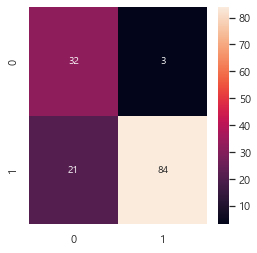

In [33]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix
ocsvm = OneClassSVM(nu=nu_percentage)
ocsvm.fit(X_train, y_train)
y_predict= ocsvm.predict(X_test)
df_test['onesvm_anomaly']= y_predict
df_test.head(3)
cm= confusion_matrix(df_test['normal'], df_test['onesvm_anomaly'])
plt.rcParams["figure.figsize"] = (4,4)
sns.heatmap(cm, annot=True)

In [34]:
from sklearn.metrics import classification_report
target_names = ['Normal(1)', 'Abnormal(-1)']
print(classification_report(df_test['normal'], df_test['onesvm_anomaly'], target_names=target_names))

              precision    recall  f1-score   support

   Normal(1)       0.60      0.91      0.73        35
Abnormal(-1)       0.97      0.80      0.88       105

    accuracy                           0.83       140
   macro avg       0.78      0.86      0.80       140
weighted avg       0.88      0.83      0.84       140



### 비지도학습

OneClassSVM(nu=0.36917562724014336)

<AxesSubplot:>

              precision    recall  f1-score   support

   Normal(1)       0.60      0.91      0.73        35
Abnormal(-1)       0.97      0.80      0.88       105

    accuracy                           0.83       140
   macro avg       0.78      0.86      0.80       140
weighted avg       0.88      0.83      0.84       140



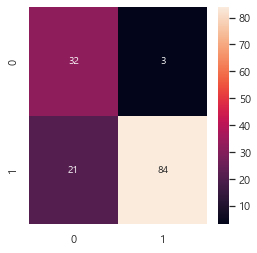

In [35]:
ocsvm = OneClassSVM(nu=nu_percentage)
ocsvm.fit(X_train)
y_class =ocsvm.predict(X_test)
df_test['onesvm_anomaly']= y_class
cm=confusion_matrix(df_test['normal'], df_test['onesvm_anomaly'])
plt.rcParams["figure.figsize"] = (4,4)
sns.heatmap(cm, annot=True)
print(classification_report(df_test['normal'], df_test['onesvm_anomaly'], target_names=target_names))

# 예제1
예측한 y값이 1은 정상(inlier)을, -1은 이상치(outlier)

In [36]:
from sklearn.svm import OneClassSVM
X = [[0], [0.44], [0.45], [0.46], [1]]
X
clf = OneClassSVM(gamma='auto').fit(X)
clf.predict(X)

[[0], [0.44], [0.45], [0.46], [1]]

array([-1,  1,  1,  1, -1], dtype=int64)

In [37]:
clf.decision_function(X)
clf.decision_function(X).round(2)

array([-2.74925564e-01,  5.28455635e-09,  8.06251090e-04,  1.35696904e-03,
       -3.21513634e-01])

array([-0.27,  0.  ,  0.  ,  0.  , -0.32])

In [38]:
clf.score_samples(X)

array([1.77987316, 2.05479873, 2.05560497, 2.05615569, 1.73328509])

# 예제 2
- https://scikit-learn.org/stable/auto_examples/svm/plot_oneclass.html#one-class-svm-with-non-linear-kernel-rbf

In [39]:
from sklearn import svm
import matplotlib.pyplot as plt
import matplotlib.font_manager

## 1. 훈련데이터 생성(outliers가 없음, 모두 정상 데이터)
## 1.1 Generate data (X)

array([[ 0.15504252,  0.53096931],
       [ 0.06326192, -0.0096972 ],
       [ 0.2482016 ,  0.26072146],
       [ 0.25012161, -0.4018037 ],
       [-0.3043002 , -0.17454049]])

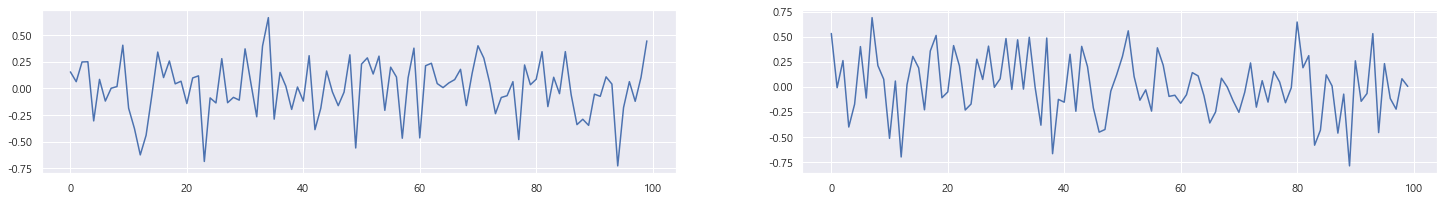

In [40]:
X = 0.3 * np.random.randn(100, 2)
X[0:5]
plt.rcParams["figure.figsize"] = (25,3)
fig, ax = plt.subplots(ncols=2) # 1 row by 2 columns
ax[0].plot(X[:, 0])
ax[1].plot(X[:, 1])

## 1.2 Generate train_data (X_train)

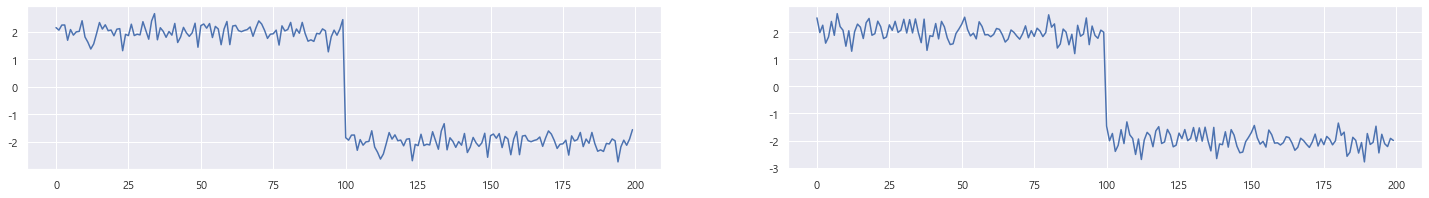

In [41]:
X_train = np.r_[X + 2, X - 2]
fig, ax = plt.subplots(ncols=2) # 1 row by 2 columns
ax[0].plot(X_train[:, 0])
ax[1].plot(X_train[:, 1])

## <font color='purple'> Case 1. X를 학습하여 X를 예측

In [42]:
clf = svm.OneClassSVM(nu=0.001, kernel="rbf", gamma=0.1)
clf.fit(X).predict(X)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

### '-1'은 이상치로 x1, x2가 둘중에 하나가 과도하게 이상하면 '-1'판정(다변량분석)

<BarContainer object of 100 artists>

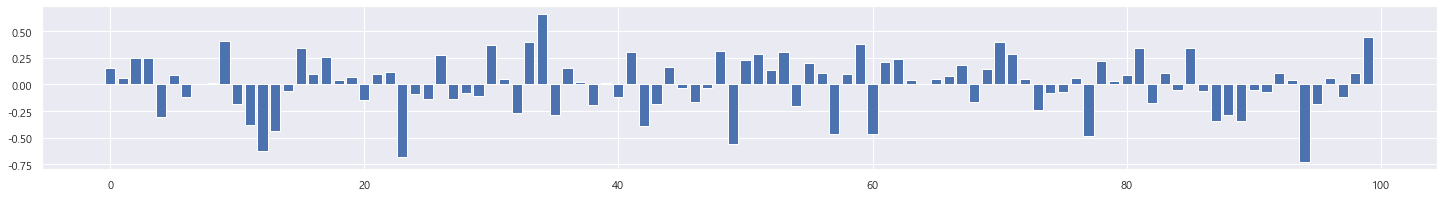

<BarContainer object of 100 artists>

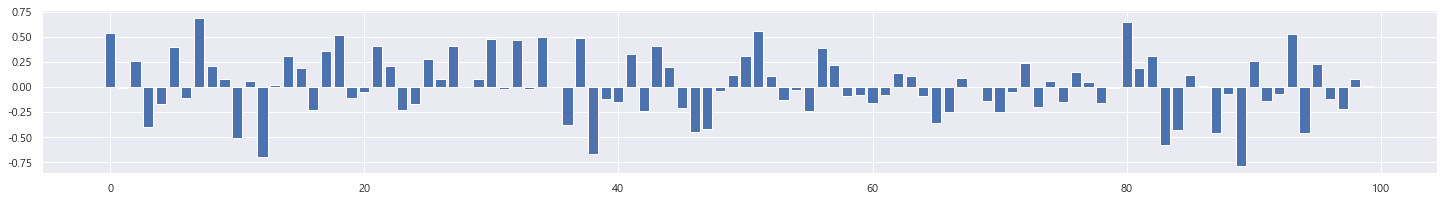

In [43]:
plt.bar(np.arange(len(X[:, 0])),X[:, 0]);plt.show()
plt.bar(np.arange(len(X[:, 1])),X[:, 1])

### 단변량의 이상치 탐색 결과와는 틀리다

In [44]:
clf.fit(X).predict(X)
clf.fit(X[:,0].reshape(-1,1)).predict(X[:,0].reshape(-1,1))
clf.fit(X[:,1].reshape(-1,1)).predict(X[:,1].reshape(-1,1))

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

### X로 학습하여 X_train을 이상치 탐색하면 모두 '-1' 로 이상치로 판정

In [45]:
clf.fit(X).predict(X_train)

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=int64)

## 3. 새로운 데이터 생성
## 3.1 X_test 20개 생성

In [46]:
X = 0.3 * np.random.randn(20, 2)  
X_test = np.r_[X + 2, X - 2]

## 3.2  비정상데이터(X_outliers) 20개 생성

In [47]:
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

### 새로운 정상데이터(X_test)와 비정상데이터(X_outliers) 그래프

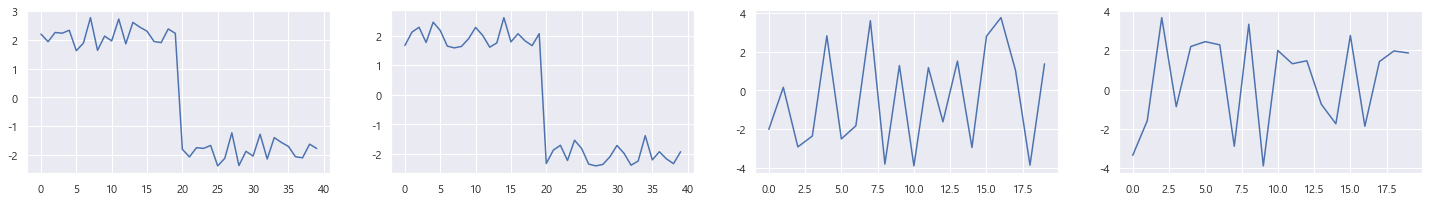

In [48]:
fig, ax = plt.subplots(ncols=4) # 1 row by 4 columns
ax[0].plot(X_test[:, 0])
ax[1].plot(X_test[:, 1])
ax[2].plot(X_outliers[:, 0])
ax[3].plot(X_outliers[:, 1])

## 3.3 학습과 예측
- 주로 kernel로 RBF사용 
- One Class SVM는 이상치가 없는 정상적인 훈련데이터를 학습하여 새로운 데이터를 분류(이진분류)
        * nu is an upper bound on the fraction of training errors and a lower bound of the fraction of support vectors.
          Should be in the interval (0, 1]. By default 0.5 will be taken. (margin error와 관계있음)
        * 파라미터 nu가 0.5라는 것은 훈련데이터의 misclassification error는 최대 5%라는 것이고 margin error는 최소 5%라는 
          (즉, 최소한 lower bound 마진에러를 감수하고 최대한 분류에러의 upper bound 확보)
### 예측
- OneClassSVM으로 각각의 데이터를 이진분류 예측 판단한 labeled y를 구한다

In [49]:
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_train

OneClassSVM(gamma=0.1, nu=0.1)

array([-1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1], dtype=int64)

In [50]:
y_pred_test = clf.predict(X_test)
y_pred_test
y_pred_outliers = clf.predict(X_outliers)
y_pred_outliers

array([ 1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1, -1,  1, -1, -1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1, -1,
       -1,  1,  1,  1, -1,  1], dtype=int64)

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1,  1], dtype=int64)

- y_pred_test는 새로운 데이터로 정상이 많은 데이터로 이상치 '-1'이 가끔 있다고 예측
- y_pred_outliers는 모두 비정상 --> 예측값이 '-1'이면 error임,

In [51]:
n_error_train = y_pred_train[y_pred_train == -1].size
print(f'X_train({len(X_train)})에서 오류 개수는 {n_error_train}, 오류확률 {n_error_train/len(X_train)*100} %')
n_error_test = y_pred_test[y_pred_test == -1].size
print(f'X_test({len(X_test)})에서 오류 개수는 {n_error_test}, 오류확률 {n_error_test/len(X_test)*100} %')
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size
print(f'X_outliers({len(X_outliers)})에서 오류 개수는 {n_error_outliers}, 오류확률 {n_error_outliers/len(X_outliers)*100} %')

X_train(200)에서 오류 개수는 19, 오류확률 9.5 %
X_test(40)에서 오류 개수는 11, 오류확률 27.500000000000004 %
X_outliers(20)에서 오류 개수는 1, 오류확률 5.0 %


Text(0.5, 1.0, 'Novelty Detection')

(-5.0, 5.0, -5.0, 5.0)

(-5.0, 5.0)

(-5.0, 5.0)

Text(0.5, 0, 'error train: 19/200 ; errors novel regular: 11/40 ; errors novel abnormal: 1/40')

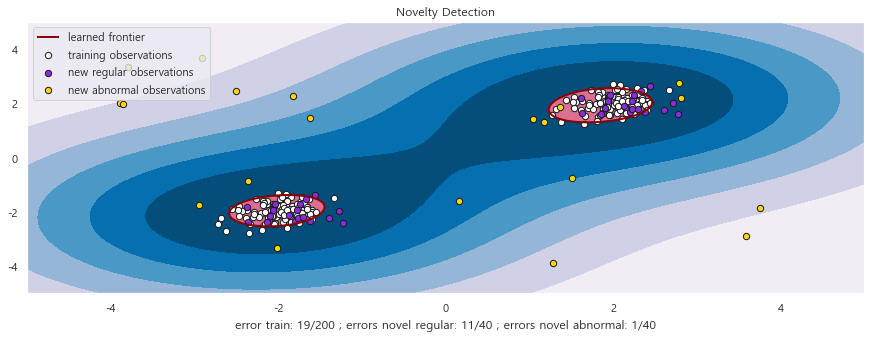

In [54]:
# plot the line, the points, and the nearest vectors to the plane

# 생성 된 그리드 포인트의 수평 및 수직 좌표 행렬 초기화
xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig = plt.figure(figsize=(15,5))
plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s,
                 edgecolors='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s,
                edgecolors='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "error train: %d/200 ; errors novel regular: %d/40 ; "
    "errors novel abnormal: %d/40"
    % (n_error_train, n_error_test, n_error_outliers))
plt.show()

# End